# Punto 4: Modelamiento, Evaluación e Interpretación

# Estudiantes:
* Diego Castro Díaz
* Isabella Orozco Jordán
* Manuela Idárraga Gómez


Este notebook desarrolla el **ciclo de modelamiento predictivo** sobre el dataset de Uber (`data.csv`)

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [2]:
data = pd.read_csv('./data/data.csv')
data.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,23/03/2024,12:29:38,CNR5884300,NoDriverFound,CID1982111,eBike,PalamVihar,Jhilmil,0.0,0.0,...,NaN,0,NaN,0,NaN,0,0.00,4.23,4.4,NaN
1,29/11/2024,18:01:39,CNR1326809,Incomplete,CID4604802,GoSedan,ShastriNagar,GurgaonSector56,4.9,0.0,...,NaN,0,NaN,1,VehicleBreakdown,237,5.73,4.23,4.4,UPI
2,23/08/2024,8:56:10,CNR8494506,Completed,CID9202816,Auto,Khandsa,MalviyaNagar,13.4,0.0,...,NaN,0,NaN,0,NaN,627,13.58,4.90,4.9,DebitCard
3,21/10/2024,17:17:25,CNR8906825,Completed,CID2610914,PremierSedan,CentralSecretariat,Inderlok,13.1,0.0,...,NaN,0,NaN,0,NaN,416,34.02,4.60,5.0,UPI
4,16/09/2024,22:08:00,CNR1950162,Completed,CID9933542,Bike,GhitorniVillage,KhanMarket,5.3,0.0,...,NaN,0,NaN,0,NaN,737,48.21,4.10,4.3,UPI


In [3]:
target = 'Booking Status'
y = data[target].astype(str)
X = data.drop(columns=[target])

num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
cat_cols = [c for c in X.columns if c not in num_cols]
print("Variables numéricas:", num_cols)
print("Variables categóricas:", cat_cols)

Variables numéricas: ['Avg VTAT', 'Avg CTAT', 'Cancelled Rides by Customer', 'Cancelled Rides by Driver', 'Incomplete Rides', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']
Variables categóricas: ['Date', 'Time', 'Booking ID', 'Customer ID', 'Vehicle Type', 'Pickup Location', 'Drop Location', 'Reason for cancelling by Customer', 'Driver Cancellation Reason', 'Incomplete Rides Reason', 'Payment Method']


In [4]:
def cambiodetipo(array, tipo):
    for each in array:
        data[each] = data[each].astype(tipo);

In [5]:
#Correccion de tipo de datos
variables_categoricas_a_corregir = ['Vehicle Type', 'Booking Status', 'Reason for cancelling by Customer',
                                    'Driver Cancellation Reason', 'Incomplete Rides Reason', 'Payment Method']
cambiodetipo(variables_categoricas_a_corregir, 'category')
cambiodetipo(['Pickup Location', 'Drop Location', 'Booking ID', 'Customer ID'], 'string')
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Date                               150000 non-null  datetime64[ns]
 1   Time                               150000 non-null  datetime64[ns]
 2   Booking ID                         150000 non-null  string        
 3   Booking Status                     150000 non-null  category      
 4   Customer ID                        150000 non-null  string        
 5   Vehicle Type                       150000 non-null  category      
 6   Pickup Location                    150000 non-null  string        
 7   Drop Location                      150000 non-null  string        
 8   Avg VTAT                           150000 non-null  float64       
 9   Avg CTAT                           150000 non-null  float64       
 10  Cancelled Rides by C

In [6]:
min_max_scaler = MinMaxScaler()
variables_numericas = ['Cancelled Rides by Customer', 'Cancelled Rides by Driver', 'Incomplete Rides']
min_max_scaler.fit(data[variables_numericas])  #Ajuste de los parametros: max - min
data[variables_numericas] = min_max_scaler.transform(data[variables_numericas])
data.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,1900-01-01 12:29:38,CNR5884300,NoDriverFound,CID1982111,eBike,PalamVihar,Jhilmil,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,0.00,4.23,4.4,NaN
1,2024-11-29,1900-01-01 18:01:39,CNR1326809,Incomplete,CID4604802,GoSedan,ShastriNagar,GurgaonSector56,4.9,0.0,...,NaN,0.0,NaN,1.0,VehicleBreakdown,237,5.73,4.23,4.4,UPI
2,2024-08-23,1900-01-01 08:56:10,CNR8494506,Completed,CID9202816,Auto,Khandsa,MalviyaNagar,13.4,0.0,...,NaN,0.0,NaN,0.0,NaN,627,13.58,4.90,4.9,DebitCard
3,2024-10-21,1900-01-01 17:17:25,CNR8906825,Completed,CID2610914,PremierSedan,CentralSecretariat,Inderlok,13.1,0.0,...,NaN,0.0,NaN,0.0,NaN,416,34.02,4.60,5.0,UPI
4,2024-09-16,1900-01-01 22:08:00,CNR1950162,Completed,CID9933542,Bike,GhitorniVillage,KhanMarket,5.3,0.0,...,NaN,0.0,NaN,0.0,NaN,737,48.21,4.10,4.3,UPI


In [7]:
#Eliminacion de variables
selected_data = data.copy()
selected_data = selected_data.drop(
    columns=['Booking ID', 'Customer ID', 'Vehicle Type', 'Pickup Location', 'Drop Location', 'Date', 'Time',
             'Customer Rating', 'Driver Ratings'])
selected_data.head()

,Booking Status,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Payment Method
0,NoDriverFound,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0,0.00,NaN
1,Incomplete,4.9,0.0,0.0,NaN,0.0,NaN,1.0,VehicleBreakdown,237,5.73,UPI
2,Completed,13.4,0.0,0.0,NaN,0.0,NaN,0.0,NaN,627,13.58,DebitCard
3,Completed,13.1,0.0,0.0,NaN,0.0,NaN,0.0,NaN,416,34.02,UPI
4,Completed,5.3,0.0,0.0,NaN,0.0,NaN,0.0,NaN,737,48.21,UPI


In [8]:
#Reduccion de dimensionalidad
# Cash, NA, Debit
mapa_pago = {
    'DebitCard': 'Debit',
    'CreditCard': 'Debit',
    'UberWallet': 'Debit',
    'Cash': 'Cash',
    'UPI': 'Debit',
}
selected_data['Payment Method'] = selected_data['Payment Method'].map(mapa_pago)
selected_data['Payment Method'] = selected_data['Payment Method'].astype('category');
selected_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Booking Status                     150000 non-null  category
 1   Avg VTAT                           150000 non-null  float64 
 2   Avg CTAT                           150000 non-null  float64 
 3   Cancelled Rides by Customer        150000 non-null  float64 
 4   Reason for cancelling by Customer  10500 non-null   category
 5   Cancelled Rides by Driver          150000 non-null  float64 
 6   Driver Cancellation Reason         27000 non-null   category
 7   Incomplete Rides                   150000 non-null  float64 
 8   Incomplete Rides Reason            9000 non-null    category
 9   Booking Value                      150000 non-null  int64   
 10  Ride Distance                      150000 non-null  float64 
 11  Payment Method            

<Axes: xlabel='Ride Distance'>

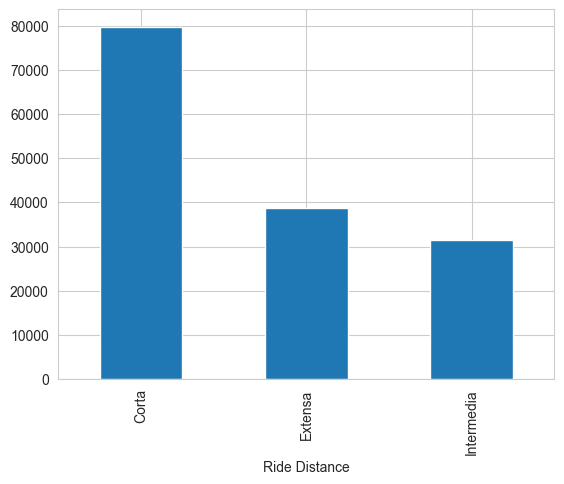

In [9]:
# Transformacion de variables
distance_bins = [0, 15, 30, float('inf')]
distance_labels = ['Corta', 'Intermedia', 'Extensa']

selected_data['Ride Distance'] = pd.cut(selected_data['Ride Distance'], bins=distance_bins, labels=distance_labels,
                                        include_lowest=True)
selected_data['Ride Distance'].value_counts().plot(kind='bar')

<Axes: xlabel='Avg CTAT'>

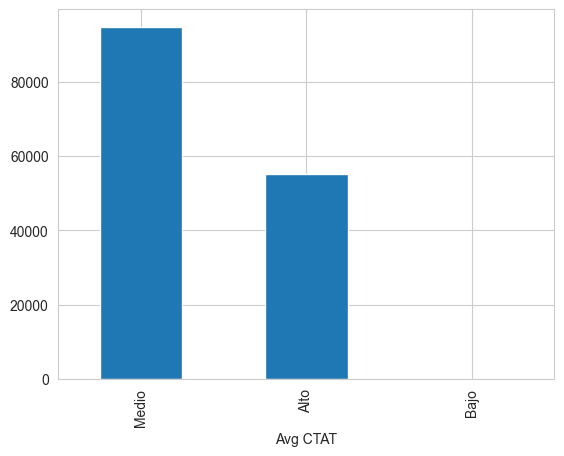

In [10]:
# Transformacion de variables
ctat_bins = [0, 10, 45, float('inf')]
ctat_labels = ['Alto', 'Medio', 'Bajo']

selected_data['Avg CTAT'] = pd.cut(selected_data['Avg CTAT'], bins=ctat_bins, labels=ctat_labels, include_lowest=True)
selected_data['Avg CTAT'].value_counts().plot(kind='bar')

<Axes: xlabel='Avg VTAT'>

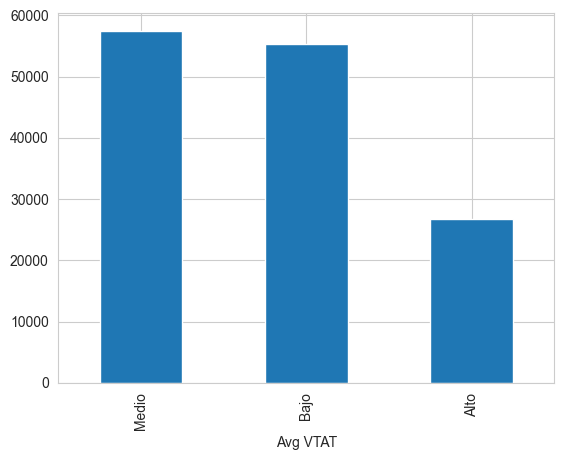

In [11]:
vtat_bins = [2, 7, 12, 20]
vtat_labels = ['Bajo', 'Medio', 'Alto']

selected_data['Avg VTAT'] = pd.cut(
    selected_data['Avg VTAT'],
    bins=vtat_bins,
    labels=vtat_labels,
    include_lowest=True
)
selected_data['Avg VTAT'].value_counts().plot(kind='bar')


In [12]:
#LabelEncoder para la variable objetivo
labelencoder = LabelEncoder()
selected_data["Booking Status"] = labelencoder.fit_transform(data["Booking Status"])
data.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,1900-01-01 12:29:38,CNR5884300,NoDriverFound,CID1982111,eBike,PalamVihar,Jhilmil,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0,0.00,4.23,4.4,NaN
1,2024-11-29,1900-01-01 18:01:39,CNR1326809,Incomplete,CID4604802,GoSedan,ShastriNagar,GurgaonSector56,4.9,0.0,...,NaN,0.0,NaN,1.0,VehicleBreakdown,237,5.73,4.23,4.4,UPI
2,2024-08-23,1900-01-01 08:56:10,CNR8494506,Completed,CID9202816,Auto,Khandsa,MalviyaNagar,13.4,0.0,...,NaN,0.0,NaN,0.0,NaN,627,13.58,4.90,4.9,DebitCard
3,2024-10-21,1900-01-01 17:17:25,CNR8906825,Completed,CID2610914,PremierSedan,CentralSecretariat,Inderlok,13.1,0.0,...,NaN,0.0,NaN,0.0,NaN,416,34.02,4.60,5.0,UPI
4,2024-09-16,1900-01-01 22:08:00,CNR1950162,Completed,CID9933542,Bike,GhitorniVillage,KhanMarket,5.3,0.0,...,NaN,0.0,NaN,0.0,NaN,737,48.21,4.10,4.3,UPI


In [13]:
#revisionj de fuga de informacion / correlacion

X = selected_data.drop(columns=['Booking Status'])
y = selected_data['Booking Status']

X_enc = X.copy()
for col in X_enc.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col].astype(str))

# Calcular importancia de cada variable respecto al target
mi = mutual_info_classif(X_enc, y, discrete_features='auto')

mi_scores = pd.Series(mi, index=X_enc.columns).sort_values(ascending=False)
print(mi_scores)

Payment Method                       0.634266
Booking Value                        0.627254
Avg CTAT                             0.509718
Driver Cancellation Reason           0.480842
Cancelled Rides by Driver            0.474208
Avg VTAT                             0.337822
Ride Distance                        0.315799
Reason for cancelling by Customer    0.269088
Cancelled Rides by Customer          0.255197
Incomplete Rides Reason              0.242695
Incomplete Rides                     0.228811
dtype: float64


<Axes: ylabel='Frequency'>

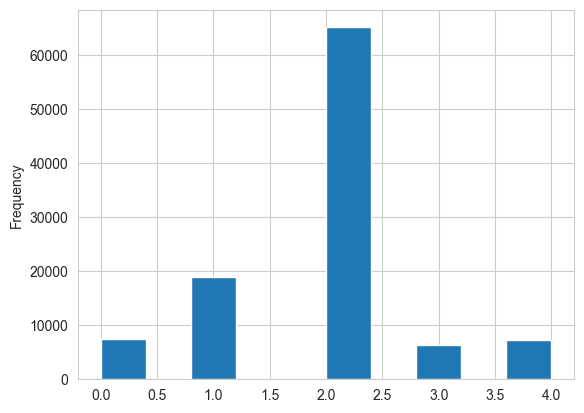

In [14]:
cols_fuga = [
    'Driver Cancellation Reason',
    'Cancelled Rides by Driver',
    'Reason for cancelling by Customer',
    'Cancelled Rides by Customer',
    'Incomplete Rides Reason',
    'Incomplete Rides'
]
#No sirven para predecir, porque estan construidas con la misma informacion que el target.
X = selected_data.drop(columns=cols_fuga + ['Booking Status'])
Y = selected_data['Booking Status']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)  #En regresion no es muestreo estratificado
Y_train.plot(kind='hist')

In [15]:
# Copia del dataset
X_enc = X.copy()

# DecisionTreeClassifier no trabajka con objetos o cats
for col in X_enc.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X_enc[col].astype(str))

X_train, X_test, Y_train, Y_test = train_test_split(X_enc, Y, test_size=0.3, random_state=42)


In [16]:
#Arbol de clasificación
#class_weight='balanced' balancea automatico
model_dt = DecisionTreeClassifier(criterion='gini', min_samples_leaf=20, max_depth=5, class_weight='balanced')
model_dt.fit(X_train, Y_train)

#Evaluación
Y_pred = model_dt.predict(X_test)
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))


                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.99      0.67      0.80     27921
         Incomplete       0.21      0.90      0.34      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.76     45000
          macro avg       0.81      0.82      0.75     45000
       weighted avg       0.92      0.76      0.80     45000



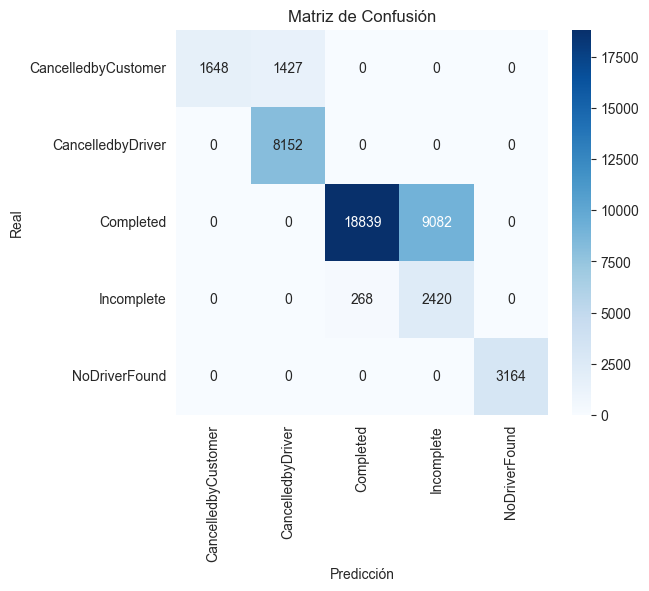

In [17]:
cm = metrics.confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labelencoder.classes_,
            yticklabels=labelencoder.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

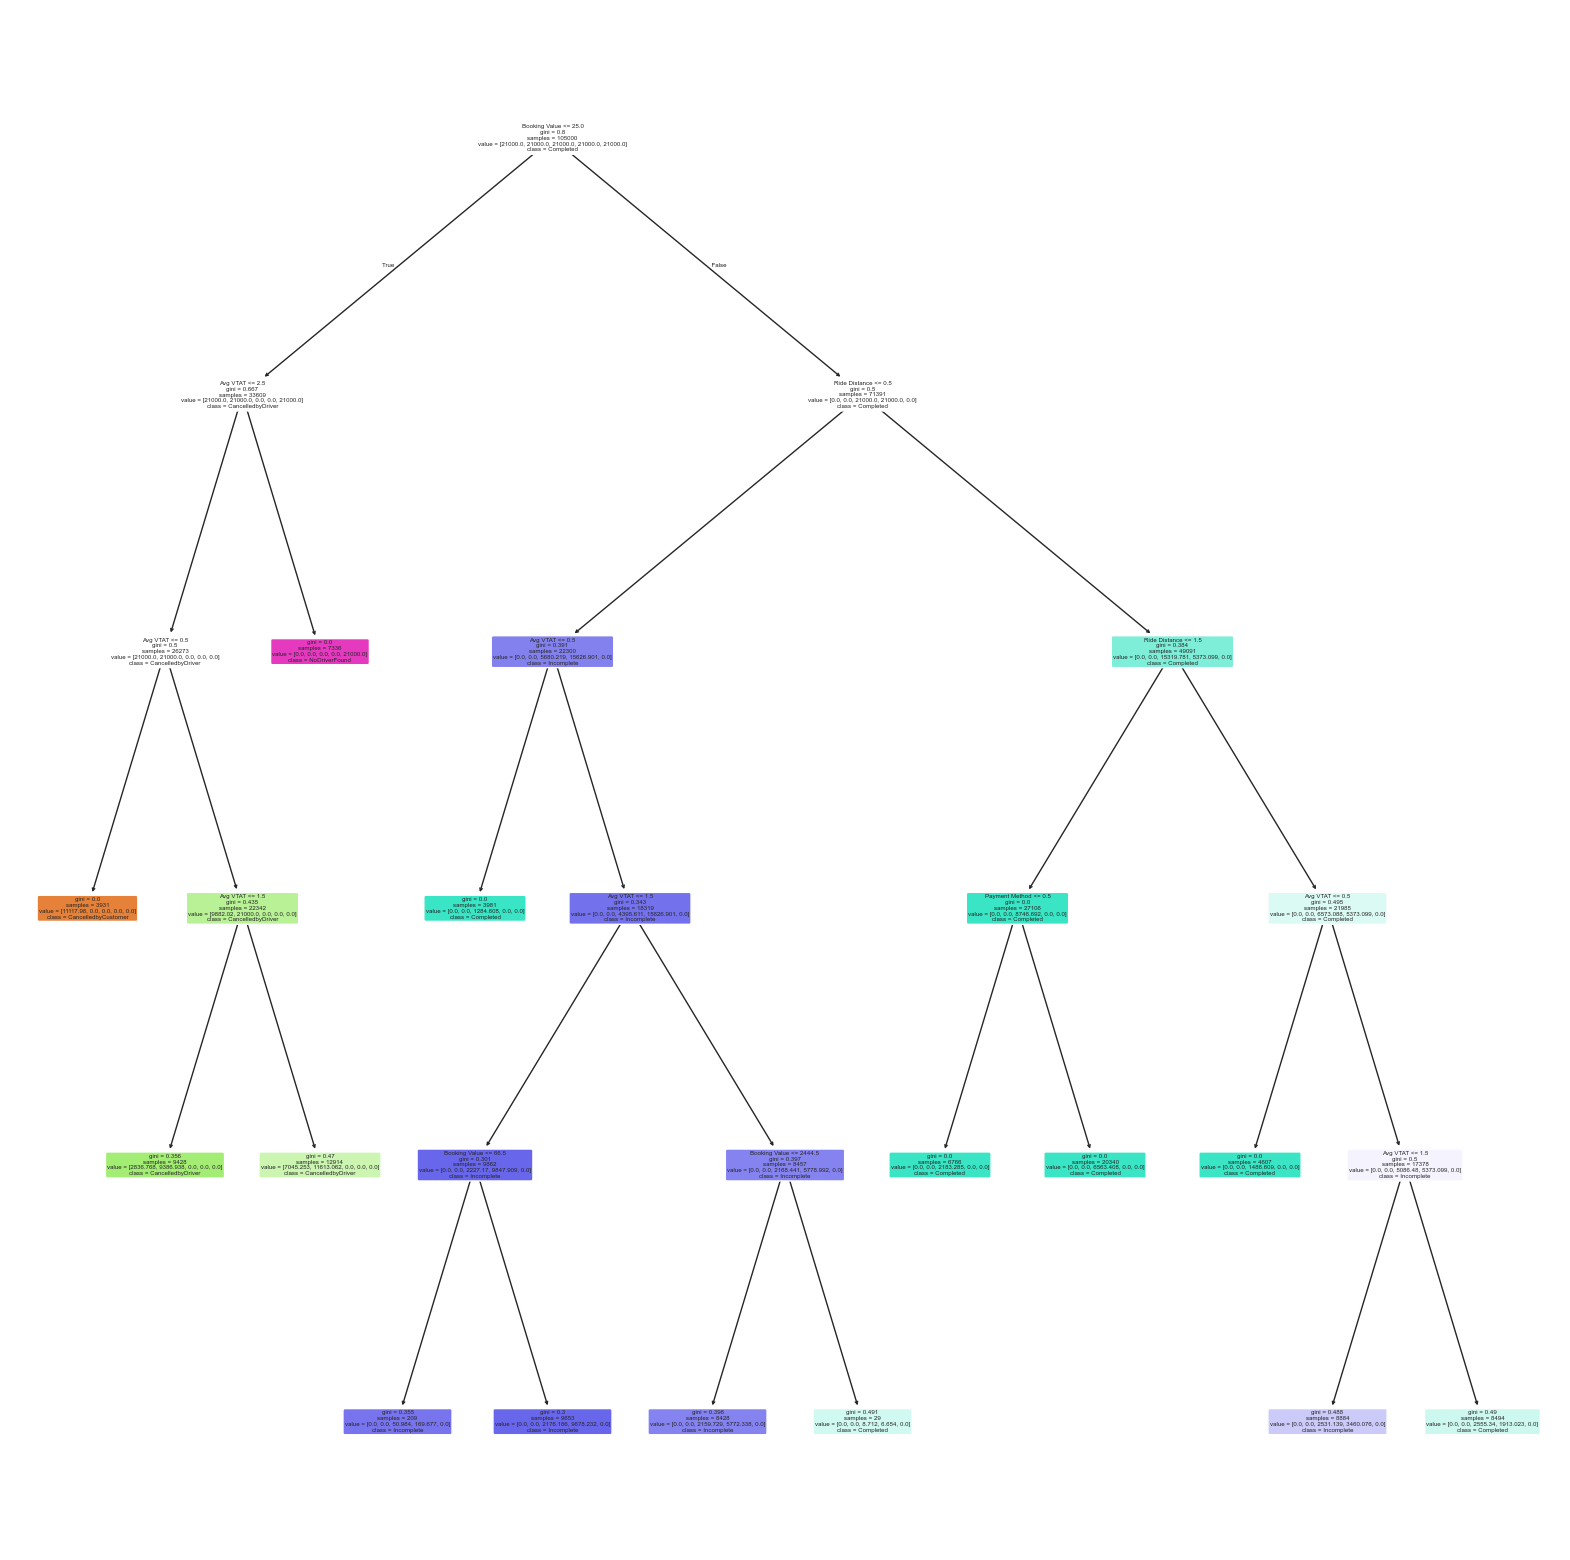

In [18]:
plt.figure(figsize=(20, 20))
plot_tree(model_dt, feature_names=X_train.columns.values, class_names=labelencoder.classes_, rounded=True, filled=True)
plt.show()

In [19]:
#Método Perezoso
model_knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
model_knn.fit(X_train, Y_train)

#Evaluación
Y_pred = model_knn.predict(X_test)
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.92      0.92      0.92     27921
         Incomplete       0.20      0.20      0.20      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.87     45000
          macro avg       0.79      0.73      0.75     45000
       weighted avg       0.88      0.87      0.87     45000



In [20]:
smote = SMOTE(random_state=42)
X_res, Y_res = smote.fit_resample(X_train, Y_train)
print("Tamaño original:", X_train.shape, " → Balanceado con SMOTE:", X_res.shape)
#Necesito usar smote para balancear la clase, similar a lo del arbol

#Red neuronal
model_rn = MLPClassifier(activation="relu", hidden_layer_sizes=(25), learning_rate='constant',
                         learning_rate_init=0.02, momentum=0.3, max_iter=500, verbose=False, random_state=42)
model_rn.fit(X_res, Y_res)

#Evaluación
Y_pred = model_rn.predict(X_test)
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

Tamaño original: (105000, 5)  → Balanceado con SMOTE: (325395, 5)
                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.97      0.73      0.83     27921
         Incomplete       0.21      0.73      0.32      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.78     45000
          macro avg       0.80      0.80      0.75     45000
       weighted avg       0.90      0.78      0.82     45000



In [21]:
#Bagging: Knn
modelo_base = KNeighborsClassifier(n_neighbors=1, metric='euclidean')

model_bag = BaggingClassifier(modelo_base, n_estimators=10, max_samples=0.6)  #n_estimators=100
model_bag.fit(X_train, Y_train)  #70%

#Evaluación
Y_pred = model_bag.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.92      0.98      0.95     27921
         Incomplete       0.23      0.07      0.11      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.90     45000
          macro avg       0.80      0.72      0.73     45000
       weighted avg       0.87      0.90      0.88     45000



In [22]:
#Random Forest
model_rf = RandomForestClassifier(n_estimators=100, max_samples=0.7, criterion='gini',
                                  max_depth=None, min_samples_leaf=2)
model_rf.fit(X_train, Y_train)  #70%

#Evaluación
Y_pred = model_rf.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.92      0.98      0.95     27921
         Incomplete       0.27      0.07      0.11      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.90     45000
          macro avg       0.81      0.72      0.74     45000
       weighted avg       0.88      0.90      0.88     45000



In [23]:
# Se imprimen la importancia de las características
print('Importancia de las características')
for i, j in sorted(zip(X_train.columns, model_rf.feature_importances_)):
    print(i, j)

Importancia de las características
Avg CTAT 0.08736472927438245
Avg VTAT 0.3005830206085312
Booking Value 0.34002551305853723
Payment Method 0.21126282596401377
Ride Distance 0.060763911094535404


In [24]:
#AdaBoost:Adaptive Boosting
#Aplicando smote, no resulto :/
# smote = SMOTE(random_state=42)
# X_res, Y_res = smote.fit_resample(X_train, Y_train)

modelo_base = DecisionTreeClassifier(max_depth=1, random_state=42)
model_boos = AdaBoostClassifier(
    modelo_base,
    n_estimators=200,
    random_state=42
)
model_boos.fit(X_train, Y_train)  #70%

#Evaluación
Y_pred = model_boos.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

# TODO: este esta jodido revisarlo



                     precision    recall  f1-score   support

CancelledbyCustomer       0.00      0.00      0.00      3075
  CancelledbyDriver       0.57      1.00      0.72      8152
          Completed       0.91      1.00      0.95     27921
         Incomplete       0.00      0.00      0.00      2688
      NoDriverFound       0.00      0.00      0.00      3164

           accuracy                           0.80     45000
          macro avg       0.30      0.40      0.34     45000
       weighted avg       0.67      0.80      0.72     45000



/Users/dicastro/Desktop/INT_NEG/MineriaDeDatos/UberMineria/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dicastro/Desktop/INT_NEG/MineriaDeDatos/UberMineria/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dicastro/Desktop/INT_NEG/MineriaDeDatos/UberMineria/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

In [25]:
# Gradient Boosting

#tasa de aprendizaje controla el tamaño de la actualización de cada modelo (contribución de cada nuevo árbol)
model_gbc = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42)
model_gbc.fit(X_train, Y_train)  #70%

#Evaluación
Y_pred = model_gbc.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.91      1.00      0.95     27921
         Incomplete       0.00      0.00      0.00      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.91     45000
          macro avg       0.75      0.71      0.71     45000
       weighted avg       0.86      0.91      0.88     45000



In [26]:
# XGboost
model_xgb = xgb.XGBClassifier(
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8  #enable_categorical=True,
)

model_xgb.fit(X_train, Y_train)  #70%

#Evaluación
Y_pred = model_xgb.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.91      1.00      0.95     27921
         Incomplete       0.19      0.00      0.01      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.91     45000
          macro avg       0.79      0.71      0.72     45000
       weighted avg       0.87      0.91      0.88     45000



In [27]:
#CatBoostClassifier
model_cat = CatBoostClassifier(iterations=100, depth=10, verbose=False,
                               cat_features=[])  #Variables categóricas
model_cat.fit(X_train, Y_train)

#Evaluación
Y_pred = model_cat.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.91      1.00      0.95     27921
         Incomplete       0.21      0.00      0.01      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.91     45000
          macro avg       0.79      0.71      0.72     45000
       weighted avg       0.87      0.91      0.88     45000



In [28]:
#Votacion hard
clasificadores = [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]

model_vot_hard = VotingClassifier(estimators=clasificadores, voting='hard')
model_vot_hard.fit(X_train, Y_train)  #70%

#Evaluación
Y_pred = model_vot_hard.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.92      0.94      0.93     27921
         Incomplete       0.22      0.19      0.21      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.88     45000
          macro avg       0.80      0.73      0.75     45000
       weighted avg       0.88      0.88      0.87     45000



In [29]:
#votacion soft

clasificadores = [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]
model_vot_soft = VotingClassifier(estimators=clasificadores, voting='soft', weights=[0.3, 0.4, 0.3])
model_vot_soft.fit(X_train, Y_train)  #70%

#Evaluación
Y_pred = model_vot_soft.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.92      0.93      0.93     27921
         Incomplete       0.21      0.20      0.20      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.88     45000
          macro avg       0.80      0.73      0.75     45000
       weighted avg       0.88      0.88      0.87     45000



In [30]:
# stacking
clasificadores = [('dt', model_dt), ('knn', model_knn), ('net', model_rn)]

metodo_ensamblador = LogisticRegression()  #SVM, NN, KNN

model_stack = StackingClassifier(estimators=clasificadores, final_estimator=metodo_ensamblador)
model_stack.fit(X_train, Y_train)  #70%

#Evaluación
Y_pred = model_stack.predict(X_test)  #30%
print(metrics.classification_report(y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

                     precision    recall  f1-score   support

CancelledbyCustomer       1.00      0.54      0.70      3075
  CancelledbyDriver       0.85      1.00      0.92      8152
          Completed       0.91      1.00      0.95     27921
         Incomplete       0.00      0.00      0.00      2688
      NoDriverFound       1.00      1.00      1.00      3164

           accuracy                           0.91     45000
          macro avg       0.75      0.71      0.71     45000
       weighted avg       0.86      0.91      0.88     45000



/Users/dicastro/Desktop/INT_NEG/MineriaDeDatos/UberMineria/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dicastro/Desktop/INT_NEG/MineriaDeDatos/UberMineria/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dicastro/Desktop/INT_NEG/MineriaDeDatos/UberMineria/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

In [31]:
filename = 'Modelo_Regresion_UBER.pkl'
variables = X.columns._values
pickle.dump([model_gbc, variables, min_max_scaler], open(filename, 'wb'))